# Problem Statement

This competition wants us to create an efficient and reliable method to detect secret data hidden within innocuous-seeming digital images.

## 1. Outline

### 1.1 Evaluation Metric

1. submissions are evaluated on the weighted AUC
2. each region of the ROC curve is weighted according to these chosen parameters: 
    a) tpr_thresholds = [0.0, 0.4, 1.0]
    b) weights = [2, 1]

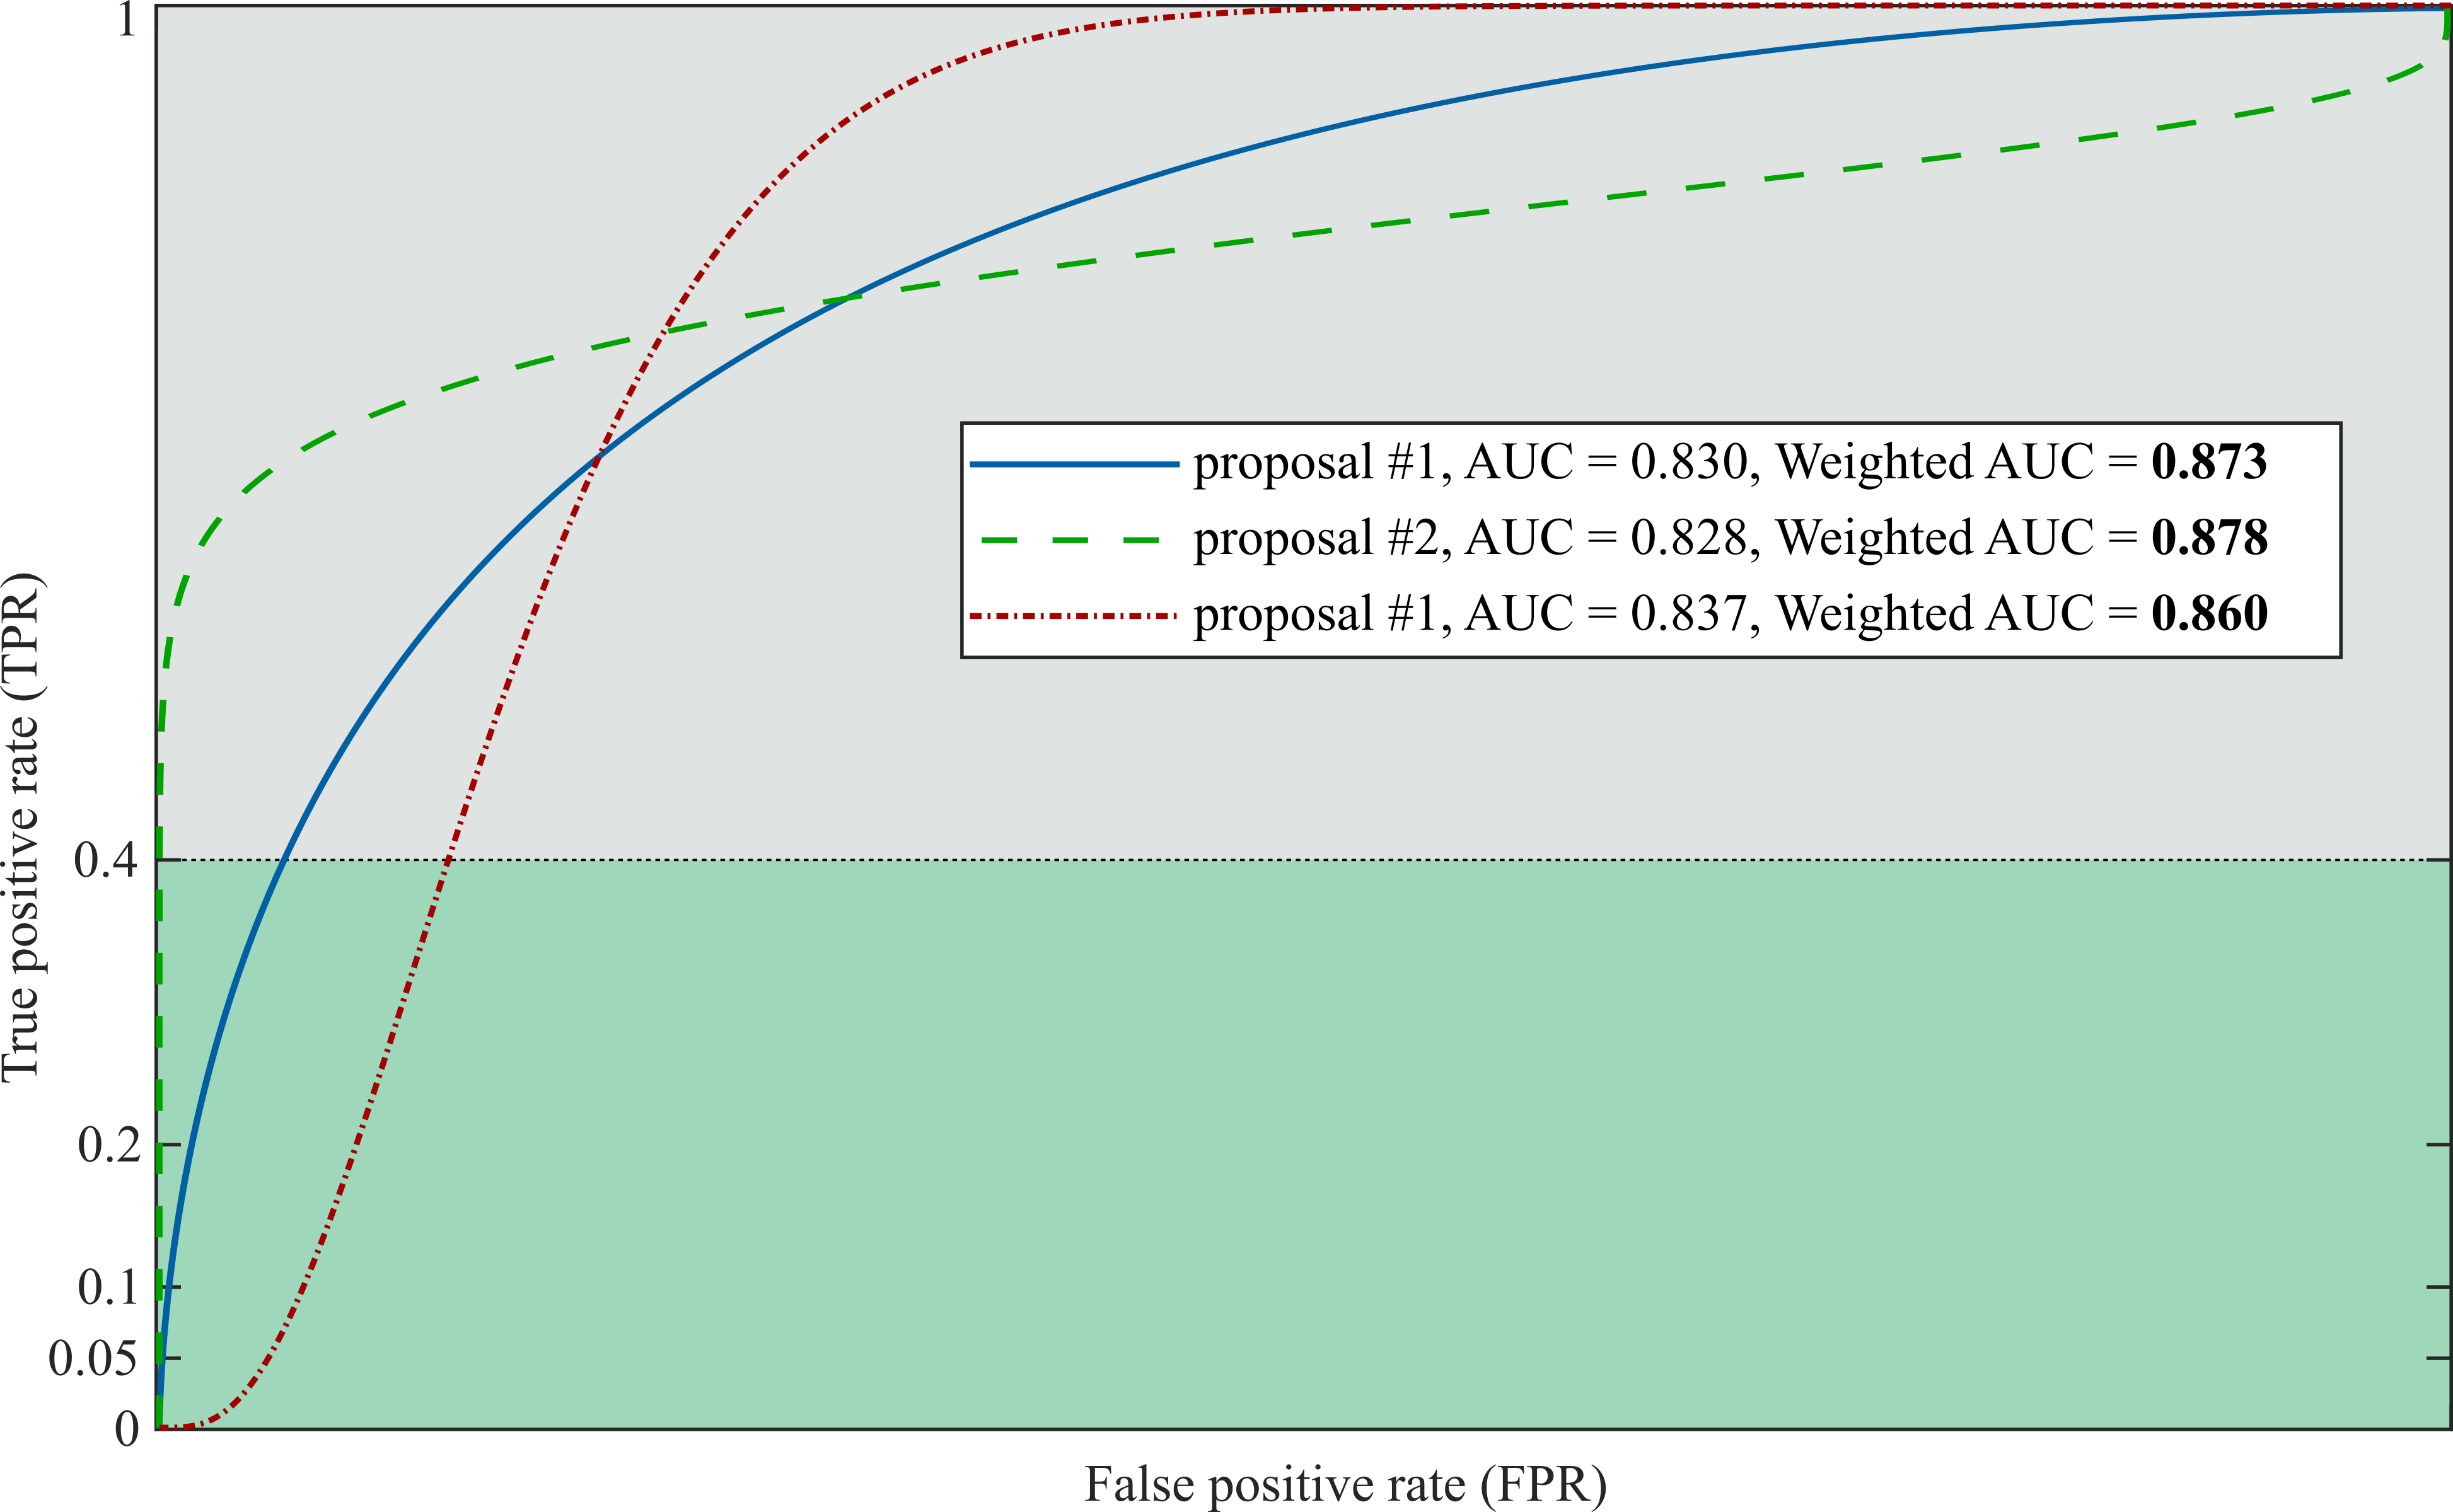

### 1.2. Data

1. Cover/ contains 75k unaltered images meant for use in training.
2. JMiPOD/ contains 75k examples of the JMiPOD algorithm applied to the cover images to hide data.
3. JUNIWARD/ contains 75k examples of the JUNIWARD algorithm applied to the cover images to hide data.
4. UERD/ contains 75k examples of the UERD algorithm applied to the cover images to hide data.
5. Test/ contains 5k test set images. These are the images for which you are predicting.
6. sample_submission.csv contains an example submission in the correct format.

## 2. Libraries 📚

In [1]:
from glob import glob
from sklearn.model_selection import GroupKFold
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import os
import random
import torchvision.transforms as transforms
from PIL import Image
from matplotlib.pyplot import imshow
from sklearn.metrics import *
import torch.nn.functional as F
import transformers
from transformers import AdamW, get_linear_schedule_with_warmup, get_constant_schedule
import warnings
warnings.filterwarnings("ignore")
from torch.optim import lr_scheduler

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


Manually setting up every seed value for the output repeatability

In [2]:
SEED = 42

# Seed everything for reproducable results
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

## 3. Importing Pre-trained Model -- EfficientNet

In [3]:
!pip install efficientnet_pytorch
# import efficientnet_pytorch
from efficientnet_pytorch import EfficientNet

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12419 sha256=69c78664a0cf6f143d1776f3fc98a9105c33a1183b920c1d0b0923b6e83fbee0
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
Successfully built efficientnet-pytorch


## 4. Preparing Data for Training

### 4.1. Getting dataframe for iterating 

Treating this as Multi-Class Classification Problem

In [4]:
%%time
dataset = []
for label, kind in enumerate(["Cover", "JMiPOD", "JUNIWARD", "UERD"]):
    for i, path in enumerate(glob("../input/alaska2-image-steganalysis/Cover/*.jpg")):
        if i == 15000 :
            break
        data = {
            "kind": kind,
            "image_name": path.split("/")[-1],
            "label": label
        }
        dataset.append(data)
random.shuffle(dataset)
dataset = pd.DataFrame(dataset)
dataset.shape

CPU times: user 1.32 s, sys: 140 ms, total: 1.46 s
Wall time: 1.73 s


(60000, 3)

### 4.2. Getting Data into different folds 

In GroupKFold image name exp 0001.jpg is present in all the four image folders, if we take 0001.jpg in train then we will not take 0001.jpg in test (from rest of the folders) and KFold CV is used for better results and better generalization while training

In [5]:
gkf = GroupKFold(n_splits = 5)

dataset.loc[:, "fold"] = 0
for fold_number, (train_index, val_index) in enumerate(gkf.split(X = dataset.index, y = dataset["label"], groups = dataset["image_name"])):
    dataset.loc[dataset.iloc[val_index].index, "fold"] = fold_number

In [6]:
dataset.head()

kind image_name  label  fold
0  JUNIWARD  29614.jpg      2     2
1     Cover  65273.jpg      0     1
2     Cover  40193.jpg      0     0
3      UERD  19580.jpg      3     0
4     Cover  04106.jpg      0     4

### 4.3. Train and  Validation Image Augmentations

In [7]:
def get_train_transforms():
    return transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.Resize((512,512)),
        transforms.ToTensor()])

def get_valid_transforms():
    return transforms.Compose([
        transforms.Resize((512,512)),
        transforms.ToTensor()])

### 4.4. Reading Train Data From the Directory

In [8]:
DATA_ROOT_PATH = '../input/alaska2-image-steganalysis'

# Function for one hot encoding of the output labels
def onehot(size, target):
    vec = torch.zeros(size, dtype = torch.float32)
    vec[target] = 1
    return vec

# Defining CLass for Accessing Data
class DatasetRetriever(Dataset):
    
    def __init__(self, kinds, labels, image_names, transforms = None):
        super().__init__()
        self.kinds = kinds
        self.labels = labels
        self.image_names = image_names
        self.transforms = transforms
        
    def __getitem__(self, idx):
        img_name = os.path.join(DATA_ROOT_PATH, self.kinds[idx], self.image_names[idx])
        image = Image.open(img_name)
        if self.transforms:
            image = self.transforms(image)
        target = onehot(4, self.labels[idx])
        return image, target
    
    def __len__(self):
        return self.kinds.shape[0]
    
    def get_labels(self):
        return list(self.labels)

### 4.5. Defining Weighted AUC Evaluation Metric

In [9]:
def alaska_weighted_auc(labels, preds, plot = False):
    
    tpr_thresholds = [0.0, 0.4, 1.0]
    weights =        [       2,   1]

    fpr, tpr, _ = roc_curve(labels, preds, pos_label=1)
    # data labels, preds
    area = np.array(tpr_thresholds)[1:] - np.array(tpr_thresholds)[:-1]     # [0.4, 0.6]
    area_normalized = np.dot(area, np.array(weights).T)  # For normalizing AUC
    
    fscore = 0
    for index, weight in enumerate(weights):
        ymin = tpr_thresholds[index]    
        ymax = tpr_thresholds[index + 1]

        mask = (tpr > ymin) & (tpr < ymax) # For Mapping y-axis values on x-axis
        x = np.concatenate([fpr[mask], np.linspace(fpr[mask][-1], 1, 100)])
        y = np.concatenate([tpr[mask], [ymax] * 100])
        y = y #(taking y as origin)
        score = auc(x, y-ymin)
        # Multiply score with weight
        weighted_score = score * weight

        fscore += weighted_score
        color = ["red", "green"]
        label = ["x ∈ [0, 1], y ∈ [0, 0.4]", "x ∈ [0, 1], y ∈ [0.4, 1.0]"]
        
        if plot:
            plt.title("Separate plots for x ∈ [0, 1], y ∈ [0, 0.4] and x ∈ [0, 1], y ∈ [0.4, 1.0]")
            plt.plot(x, y, color = color[index], label = label[index])
            plt.xlabel("False Positive rate")
            plt.ylabel("True Positive rate")
            plt.legend(loc = 2)
#           plt.plot()

        # Normalizing score
        final_score = fscore/area_normalized
        return final_score

### 4.6. Converting Multi class to Binary Classiifcation 

Getting Data Ready For Prediction

In [10]:
class RocAucMeter(object):
    
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.y_true = np.array([0, 1])
        self.y_pred = np.array([0.5, 0.5])
        self.score = 0
        
    def update(self, y_true, y_pred):
        y_true = y_true.argmax(axis=1).clip(min=0, max=1).astype(int)
        y_pred = 1 - nn.functional.softmax(torch.tensor(y_pred), dim=1)[:,0] # 1 - predicted accuracy of COVER Images
        self.y_true = np.hstack((self.y_true, y_true))
        self.y_pred = np.hstack((self.y_pred, y_pred))
        
    def score_(self):
        self.score = alaska_weighted_auc(self.y_true, self.y_pred, plot = True)
        
    @property
    def avg(self):
        return self.score

### 4.7. Function for calculating Summary Loss w

In [11]:
class AverageMeter(object):
    
    def __init__(self):
        return self.reset()
    
    def reset(self):
        self.value = 0
        self.sum = 0
        self.count = 0
        self.avg = 0
        
    def update(self, value, n = 1):
        self.value = value
        self.sum = value * n
        self.count += n
        self.avg = self.sum/self.count

In [12]:
class LabelSmoothing(nn.Module):
    
    def __init__(self, smoothing = 0.05):
        self.confidence = 1 - smoothing
        self.smoothing = smoothing
        super().__init__()
        
    def forward(self, x, target):
            x = x.float()
            target = target.float()
            
            logprobs = torch.nn.functional.log_softmax(x, dim = -1)
            nll_loss = -logprobs * target
            nll_loss = nll_loss.sum(-1)
    
            smooth_loss = -logprobs.mean(dim=-1)

            loss = self.confidence * nll_loss + self.smoothing * smooth_loss
            return loss.mean()

In [13]:
def get_net():
    net = EfficientNet.from_pretrained('efficientnet-b2')
    net._fc = nn.Linear(in_features=1408, out_features=4, bias=True)
    return net

mx = get_net()

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/checkpoints/efficientnet-b2-8bb594d6.pth



Loaded pretrained weights for efficientnet-b2


In [14]:
def get_folds_data(TRAIN_BATCH_SIZE, EPOCHS, i):
    
    fold_number = i
    train_dataset = DatasetRetriever(
        kinds = dataset[dataset["fold"] != fold_number].iloc[:, 0].values,
        image_names = dataset[dataset["fold"] != fold_number].iloc[:, 1].values,
        labels = dataset[dataset["fold"] != fold_number].iloc[:, 2].values,
        transforms = get_train_transforms()
    )

    train_data_loader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=TRAIN_BATCH_SIZE,
            drop_last=True,  # take care of last batch
            num_workers=4
    )


    valid_dataset = DatasetRetriever(
        kinds=dataset[dataset['fold'] == fold_number].kind.values,
        image_names=dataset[dataset['fold'] == fold_number].image_name.values,
        labels=dataset[dataset['fold'] == fold_number].label.values,
        transforms=get_valid_transforms()
    )



    valid_data_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=TRAIN_BATCH_SIZE,
        drop_last=False,
        num_workers=4
    )
    
    return train_data_loader, valid_data_loader

In [15]:
def loss_fxn(outputs, targets):
    loss_obj = LabelSmoothing()
    loss = loss_obj(outputs, targets)
    return loss

In [16]:
def train_model():
    device = torch.device('cuda:0')
    model = mx.to(device)
    TRAIN_BATCH_SIZE = 8
    EPOCHS = 2
    
    
    for i in range(5):     # For five folds
        
        def loss_fn(outputs, targets):
            loss_obj = LabelSmoothing()
            loss = loss_obj(outputs, targets)
            return loss
                    

        def train_loop_fn(data_loader, model, optimizer, device, scheduler=None):
            model.train()
            train_loss = AverageMeter()
            final_scores = RocAucMeter()
            for bi, (X,y) in enumerate(data_loader):
                inputs = X
                targets = y

                inputs = inputs.to(device, dtype = torch.float32)
                targets = targets.to(device, dtype=torch.float32)
                batch_size = inputs.shape[0]
                
                optimizer.zero_grad()
                outputs = model(inputs)

                loss = loss_fn(outputs, targets)
                
                loss.backward()
                optimizer.step()
                
                final_scores.update(targets.cpu().detach().numpy(), outputs.cpu().detach().numpy())
                train_loss.update(loss.detach().item(), batch_size)
                
                if scheduler is not None:
                    scheduler.step()
            
            final_scores.score_()
            
            print(f'Epoch: {e+1} | Train Loss: {train_loss.avg} | AUC: {final_scores.avg}')
            
        def eval_loop_fn(data_loader, model, device):
            model.eval()
            summary_loss = AverageMeter()
            final_scores = RocAucMeter()
            fin_targets = []
            fin_outputs = []
            for bi, (X,y) in enumerate(data_loader):
                
                with torch.no_grad():
                    inputs = X
                    targets = y

                    inputs = inputs.to(device, dtype = torch.float32)
                    targets = targets.to(device, dtype = torch.float32)
                    batch_size = inputs.shape[0]
                    
                    outputs = model(inputs)

                    targets_np = targets.cpu().detach().numpy()
                    outputs_np = outputs.cpu().detach().numpy()
                    fin_targets.append(targets_np)
                    fin_outputs.append(outputs_np)
                    
                    loss = loss_fn(outputs, targets)
                    final_scores.update(targets.cpu().detach().numpy(), outputs.cpu().detach().numpy())
                    summary_loss.update(loss.cpu().detach(), batch_size)
            
            final_scores.score_()
            
            print(f'Epoch: {e+1} | Valid Loss: {summary_loss.avg} | AUC: {final_scores.avg}')

            return np.vstack(fin_outputs), np.vstack(fin_targets)
        
        train_data_loader, valid_data_loader = get_folds_data(TRAIN_BATCH_SIZE, EPOCHS, i)

        print("\n")
        print("#"*25)
        print(f"FOLD: {i + 1}")
        print("#"*25)
        
        lr = 0.001
        num_train_steps = int(len(dataset) / TRAIN_BATCH_SIZE * EPOCHS * 0.8)
        print(f'num_train_steps = {num_train_steps}')

        optimizer = AdamW(model.parameters(), lr=lr)
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=0,
            num_training_steps=num_train_steps
        )
        
        best_score = 0
        for e in range(EPOCHS):
            train_loop_fn(train_data_loader, model, optimizer, device, scheduler=scheduler)
            o, t = eval_loop_fn(valid_data_loader, model, device)
            score = RocAucMeter()
            score.reset()
            score.update(t, o)
            score.score_()
            
            # Saving Model Weights 
            if float(score.avg) > best_score:
                best_score = score.avg
                torch.save(model.state_dict(), f"model{i}.bin")



#########################
FOLD: 1
#########################
num_train_steps = 12000
Epoch: 1 | Train Loss: 0.00019938135147094726 | AUC: 0.5207008012188773
Epoch: 1 | Valid Loss: 0.0007359529263339937 | AUC: 0.549435547978418
Epoch: 2 | Train Loss: 0.0001729706128438314 | AUC: 0.5503895457208704
Epoch: 2 | Valid Loss: 0.0007115559419617057 | AUC: 0.5584895924064059


#########################
FOLD: 2
#########################
num_train_steps = 12000
Epoch: 1 | Train Loss: 0.00016901475191116334 | AUC: 0.5489211460491004
Epoch: 1 | Valid Loss: 0.0007180871907621622 | AUC: 0.5592085215329714
Epoch: 2 | Train Loss: 0.00015824546416600546 | AUC: 0.5598423333522148
Epoch: 2 | Valid Loss: 0.0007127963472157717 | AUC: 0.5636763240372836


#########################
FOLD: 3
#########################
num_train_steps = 12000
Epoch: 1 | Train Loss: 0.00014442030588785807 | AUC: 0.5567984228942852
Epoch: 1 | Valid Loss: 0.0008842332172207534 | AUC: 0.5620447000575781
Epoch: 2 | Train Loss: 0.0001

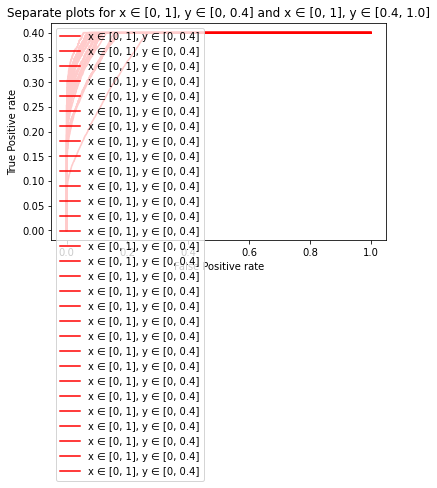

In [17]:
train_model()

This was treated on subset of Train Images (60k out of 300k). That's why this weighted AUC score was achieved, when trained on full dataset weighted AUC score of greater than 90% can be be achieved.